# Kaggle MNIST digit challenge

## Getting the data and processing it

In [93]:
# Getting the dataset from torchvision
import numpy
import torch
import matplotlib
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import pandas as pd
import os

In [94]:
# download the mnist dataset
dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = MNIST(root = 'data/', train = False, transform = transforms.ToTensor())

# splitting the dataset into validation and training for cross validation
train_ds, test_ds = random_split(dataset, [57000, 3000])

In [95]:
# getting the kaggle testdataset
test_kaggle = pd.read_csv("test.csv")

# converting it to a pytorch tensor,
test_kag = torch.tensor(test_kaggle.values, dtype = torch.float32)
print(test_kag.shape)

torch.Size([28000, 784])


In [96]:
# declaring the batch size
batch_size = 200

In [97]:
# defining the data loader for training and testing...
train_loader = DataLoader(train_ds, batch_size, shuffle = True)
validation_loader = DataLoader(test_ds, batch_size * 2)

test_loader = DataLoader(test_dataset, batch_size * 2)

# now that we have the kaggle dataset tensor, lets convert it to a data loader, we need to keep in mind that this has a different shape
test_kaggle_loader = DataLoader(test_kag, batch_size * 2)

In [98]:
# we wanna get the output and input sizes
out_size = 10 
# number of digits is obviously 10

for batch in train_loader:
    for image in batch:
        print(image.shape)
        break
    break

torch.Size([200, 1, 28, 28])


In [99]:
for batch in test_kaggle_loader:
    print(batch.shape)
    break

torch.Size([400, 784])


In [100]:
# so we have 221 images in each batch and each image has one color channel and 28x28 pixels
input_size = 28 * 28

Label: tensor(0)


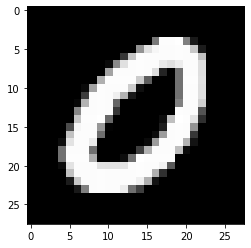

In [101]:
# lets look at one of the digit's gray scale image
images,labels = train_ds[0]
plt.imshow(images[0], cmap = "gray")
print("Label:", labels)

# Vanilla Logistic Regression using Cross entropy as the loss function

In [102]:
# creating the model...
class MnistModel_LR(nn.Module):
    
    #initialising the initialiser/constructor
    def __init__(self, input_size, out_size):
        
        # we construct a simple linear model to classify the digits with one layer...
        super().__init__()
        self.linear = nn.Linear(input_size, out_size)
    
    # forming the ff network
    def forward(self, inputs):
        inputs = inputs.reshape(-1, 784)
        out = self.linear(inputs)
        return out
    
    # training the model 
    def training_step(self, batch):
        
        images, labels = batch
        out = self(images)
        
        # calculating the loss using the cross entropy func
        loss = F.cross_entropy(out, labels)
        
        # returning the loss
        return(loss)
    
    # validation step
    def validation_step(self,batch):
        
        images, labels = batch
        out = self(images)
        
        # getting the max prob label, i.e prediction
        _, preds = torch.max(out, dim = 1)
        
        # finding the accuracy, total correct preds divided by total preds
        acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
        return(acc)
    
    # getting the results for the end of the epoch
    def epoch_end(self, epoch, acc):
        print(f"Epoch:{epoch} , accuracy on test set : {acc}")

In [103]:
# lets define the evaluation and fit functions
def evaluation(model, val_set):
    
    outputs = []
    for batch in val_set:
        outputs.append(model.validation_step(batch))
        
    accuracy_mean = torch.stack(outputs).mean()
    return accuracy_mean

# we use stochastic gradient descent to apply gradient descent in batch wise steps and optimise the losses and jumps
def fit(model, l_r, epochs, train_set, test_set, opt = torch.optim.SGD):
    
    # we keep track of all epochs using history
    history = []
    optimiser = opt(model.parameters(), l_r)
    
    for epoch in range(epochs):
        
        # training phase
        for batch in train_set:
            # applying loss and gradient descent
            loss = model.training_step(batch)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
            
        # validation phase
        result = evaluation(model, test_set)
        # prints out the accuracy on the test set
        model.epoch_end(epoch, result)
        history.append(result)
        
    return(history)

In [104]:
model_lr = MnistModel_LR(input_size, out_size)

## Training the LR model and getting the predictions

In [105]:
# evaluating using the random model with random weights
history = [evaluation(model_lr, validation_loader)]
print(history)

[tensor(0.1503)]


In [106]:
# training the model using cross validation and with different learning rates...
history = fit(model_lr, 0.1, 5, train_loader, validation_loader)

Epoch:0 , accuracy on test set : 0.8762499094009399
Epoch:1 , accuracy on test set : 0.8881250619888306
Epoch:2 , accuracy on test set : 0.893125057220459
Epoch:3 , accuracy on test set : 0.8943749666213989
Epoch:4 , accuracy on test set : 0.9003125429153442


In [107]:
history += fit(model_lr, 0.05, 5, train_loader, validation_loader)

Epoch:0 , accuracy on test set : 0.8987500667572021
Epoch:1 , accuracy on test set : 0.9012499451637268
Epoch:2 , accuracy on test set : 0.903124988079071
Epoch:3 , accuracy on test set : 0.9037500023841858
Epoch:4 , accuracy on test set : 0.9028124213218689


In [108]:
history += fit(model_lr, 0.01, 5, train_loader, validation_loader)

Epoch:0 , accuracy on test set : 0.9049999713897705
Epoch:1 , accuracy on test set : 0.9043750166893005
Epoch:2 , accuracy on test set : 0.9046874642372131
Epoch:3 , accuracy on test set : 0.9040624499320984
Epoch:4 , accuracy on test set : 0.9050000309944153


In [109]:
history += fit(model_lr, 0.005, 5, train_loader, validation_loader)

Epoch:0 , accuracy on test set : 0.9046874642372131
Epoch:1 , accuracy on test set : 0.9050000309944153
Epoch:2 , accuracy on test set : 0.9050000309944153
Epoch:3 , accuracy on test set : 0.9053124785423279
Epoch:4 , accuracy on test set : 0.9053124785423279


In [110]:
history += fit(model_lr, 0.001, 5, train_loader, validation_loader)

Epoch:0 , accuracy on test set : 0.9053124785423279
Epoch:1 , accuracy on test set : 0.9053124785423279
Epoch:2 , accuracy on test set : 0.9053124785423279
Epoch:3 , accuracy on test set : 0.9053124785423279
Epoch:4 , accuracy on test set : 0.9053124785423279


In [111]:
# getting the accuracy of our model on the test dataset(not kaggle)
preds = evaluation(model_lr, test_loader)
preds

tensor(0.9177)

In [112]:
# defining a function to find out the predicted digit
def predict(image, model):
    
    # reshaping the image size
    xb = image.unsqueeze(0)
    
    # getting the probability prediction
    yb = model(xb)
    
    # getting the maximum probability 
    _, preds  = torch.max(yb, dim = 1)
    
    # now returning the digit corresponding to the maximum probability
    return preds[0].item()

In [113]:
# checking the size of the tensor
img = test_kag[0]
xb = img.unsqueeze(0)
print(xb.shape)

torch.Size([1, 784])


Label: tensor(7) , Predicted: 7


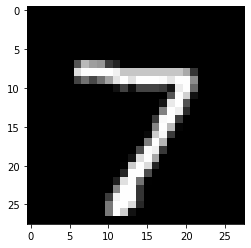

In [114]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict(img, model_lr))

In [115]:
# storing the predictions in a list
labels = []

for i in range(len(test_kag)):
    image = test_kag[i]
    labels.append(predict(image, model_lr))

In [116]:
# verifying this...
print(labels)

[2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 8, 5, 7, 4, 2, 7, 7, 7, 7, 5, 4, 2, 6, 2, 9, 5, 1, 6, 7, 7, 4, 9, 8, 7, 8, 8, 6, 1, 6, 8, 8, 3, 8, 2, 1, 2, 2, 5, 4, 1, 7, 0, 0, 0, 1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 3, 9, 2, 3, 5, 9, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0, 6, 6, 8, 4, 3, 9, 7, 4, 0, 8, 2, 0, 7, 3, 0, 5, 0, 3, 0, 0, 4, 7, 1, 7, 1, 1, 8, 3, 3, 7, 2, 8, 6, 3, 8, 7, 8, 4, 3, 5, 6, 0, 0, 0, 3, 1, 3, 0, 4, 3, 4, 5, 5, 8, 7, 7, 2, 8, 4, 3, 5, 6, 5, 8, 7, 5, 7, 8, 3, 0, 4, 5, 1, 8, 7, 6, 3, 0, 2, 7, 8, 6, 1, 3, 7, 4, 1, 2, 4, 3, 8, 2, 4, 9, 2, 1, 6, 0, 6, 1, 4, 9, 6, 0, 9, 7, 6, 9, 1, 9, 0, 8, 9, 0, 8, 4, 6, 2, 0, 9, 3, 6, 8, 2, 1, 6, 3, 4, 2, 3, 1, 3, 2, 8, 4, 6, 1, 0, 0, 4, 9, 1, 7, 3, 2, 8, 8, 6, 8, 6, 2, 8, 5, 5, 4, 8, 3, 8, 9, 7, 1, 3, 8, 4, 8, 1, 4, 3, 6, 3, 8, 5, 7, 0, 6, 8, 6, 1, 6, 0, 6, 3, 9, 8, 1, 5, 8, 4, 0, 9, 2, 0, 5, 3, 7, 8, 9, 9, 5, 7, 7, 9, 9, 6, 3, 0, 3, 3, 6, 9, 8, 2, 6, 3, 7, 1, 4, 5, 8, 5, 9, 0, 0, 3, 8, 4, 1, 8, 4, 1, 1, 9, 8, 4, 5, 1, 8, 3, 6, 3, 1, 

In [117]:
# converting the list to a csv file
labels_df = pd.DataFrame(labels)

labels_df.to_csv("submission_lr.csv", index = True)

 So i just realised that the kaggle test dataset is different from the mnist test dataset
 So we need to convert the kaggel dataset to pytorch tensor and find out the accuracy
 The dataset is edited in the beginning and we will be using it now to make preds and find the accuracy

# CNN Architecture 

In [187]:
class CNN_MNIST(nn.Module):
    #initialising the initialiser/constructor
    def __init__(self, input_size, out_size):
        
        # we construct a convolutional nn to classify the digits with multiple layers layer...
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1),
            nn.MaxPool2d(2,2),  # output = (16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # output = (32, 7, 7)
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100, 10))
    
    # forming the cnn network
    def forward(self, inputs):
        return self.network(inputs)
    
    # training the model 
    def training_step(self, batch):
        
        images, labels = batch
        out = self(images)
        
        # calculating the loss using the cross entropy function
        loss = F.cross_entropy(out, labels)
        
        # returning the loss
        return(loss)
    
    # validation step
    def validation_step(self,batch):
        
        images, labels = batch
        out = self(images)
        
        # getting the max prob label, i.e prediction
        _, preds = torch.max(out, dim = 1)
        
        # finding the accuracy, total correct preds divided by total preds
        acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
        return(acc)
    
    # getting the results for the end of the epoch
    def epoch_end(self, epoch, acc):
        print(f"Epoch:{epoch} , accuracy on test set : {acc}")

In [188]:
# using our gpu(cuda) to train the cnn

def get_default_device():
    
    # Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    
    # Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    
    # Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self): 
        # Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        # Number of batches
        return len(self.dl)

In [189]:
# using CUDA
device = get_default_device()
device

device(type='cuda')

In [190]:
# defining the model
model_cnn = CNN_MNIST(input_size, out_size)

We move the train and validation loaders to the device(cuda)

In [191]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
to_device(model_cnn, device)

test_loader = DeviceDataLoader(test_loader, device)
test_kaggle_Loader = DeviceDataLoader(test_kaggle_loader, device)

## Training the CNN model

In [192]:
# evaluating using the random model with random weights
history = [evaluation(model_cnn, validation_loader)]
print(history)

[tensor(0.1100)]


In [193]:
# training the model using cross validation and with different learning rates...
history = fit(model_cnn, 0.1, 5, train_loader, validation_loader)

Epoch:0 , accuracy on test set : 0.9424999952316284
Epoch:1 , accuracy on test set : 0.9703124761581421
Epoch:2 , accuracy on test set : 0.9778125286102295
Epoch:3 , accuracy on test set : 0.9803125262260437
Epoch:4 , accuracy on test set : 0.9818750023841858


In [194]:
history = fit(model_cnn, 0.01, 5, train_loader, validation_loader)

Epoch:0 , accuracy on test set : 0.984375
Epoch:1 , accuracy on test set : 0.9840624928474426
Epoch:2 , accuracy on test set : 0.984375
Epoch:3 , accuracy on test set : 0.9837499856948853
Epoch:4 , accuracy on test set : 0.9859375357627869


In [195]:
history = fit(model_cnn, 0.005, 5, train_loader, validation_loader)

Epoch:0 , accuracy on test set : 0.9850000143051147
Epoch:1 , accuracy on test set : 0.9850000143051147
Epoch:2 , accuracy on test set : 0.9840624928474426
Epoch:3 , accuracy on test set : 0.9846875071525574
Epoch:4 , accuracy on test set : 0.984375


In [196]:
history = fit(model_cnn, 0.001, 1, train_loader, validation_loader)

Epoch:0 , accuracy on test set : 0.9853125214576721


In [197]:
# getting the accuracy of our model on the test dataset(not kaggle)
preds = evaluation(model_cnn, test_loader)
preds

tensor(0.9872)

In [207]:
# storing the predictions in a list
labels_cnn = []

for i in range(len(test_kag)):
    
    imag = test_kag[i]
    
    imge = to_device(imag.unsqueeze(0), device)
    
    image = torch.reshape(imge, (1, 28, 28))

    labels_cnn.append(predict(image, model_cnn))
    

In [208]:
# converting the list to a csv file
labels_df = pd.DataFrame(labels_cnn)

labels_df.to_csv("submission_cnn.csv", index = True)